In [117]:
import numpy as np
import imp
import csv

cs_utils = imp.load_source('cs_utils',"/Users/tmarkovich/Dropbox (Aspuru-Guzik Lab)/Projects/cslib2/cs_utils.py")
drude_lorentz = imp.load_source('cs_utils',"/Users/tmarkovich/Dropbox (Aspuru-Guzik Lab)/Projects/cslib2/drude_lorentz.py")
Astruct = imp.load_source('Astruct', '/Users/tmarkovich/Dropbox (Aspuru-Guzik Lab)/Projects/cslib2/Astruct.py')
twist = imp.load_source('twist',"/Users/tmarkovich/Dropbox (Aspuru-Guzik Lab)/Projects/cslib2/TwIST_Solver.py")
time_range = np.array([2**0, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8])
ureg.define('wavenumber = 3.33565e-11*Hz')

%matplotlib inline

In [118]:
from pint import UnitRegistry
ureg = UnitRegistry()
ureg.enable_contexts('spectroscopy')
ureg.enable_contexts('boltzmann')
Q_ = ureg.Quantity


In [119]:
def reproduction(time, signal, lambdas, A, plotting = False):
    reproduced = np.zeros(shape=np.shape(time))
    reproduced += cs_utils.reproduce_series(A, lambdas, time)

    if(plotting):
        cs_utils.thomas_ploting(time, [signal, reproduced],
                                title='Original Signal vs Reproduction',
                                legend_label=['Original Signal', 'Reproduced'],
                                xlabel='Time [s]',
                                ylabel='Signal [Arb]')
    return reproduced


def reproduction_trafo(time, signal, lambdas, A, plotting = False):
    reproduced = np.zeros(shape=np.shape(time))
    reproduced += cs_utils.reproduce_transform(A, lambdas, time)

    if(plotting):
        cs_utils.thomas_ploting(time, [signal, reproduced],
                                title='Original Signal vs Reproduction',
                                legend_label=['Original Signal', 'Reproduced'],
                                xlabel='Time [s]',
                                ylabel='Signal [Arb]')
    return reproduced


def matrixGeneration(x, omegaMin = 0.01, omegaMax = 300, numOmega = 250, gammaMin = 1.5, gammaMax = 5, numGamma = 50):
    # Param Array Generation
    gamma_grid = np.linspace(gammaMin, gammaMax, num=numGamma)*ureg.Hz
    omega_grid = np.linspace(omegaMin, omegaMax, num=numOmega)*ureg.Hz
    length = len(gamma_grid)*len(omega_grid)
    gammaList = np.zeros(shape=(length, 1))
    omegaList = np.zeros(shape=(length, 1))
    
    ind = 0
    for i in xrange(np.shape(gamma_grid)[0]):
        for j in xrange(np.shape(omega_grid)[0]):
            gammaList[ind] = gamma_grid[i].magnitude
            omegaList[ind] = omega_grid[j].magnitude
            ind += 1
    param_array = np.hstack((gammaList, omegaList))*ureg.Hz

    A = Astruct.Astruct(drude_lorentz.time,
                          x.to('second').magnitude,
                          param_array.to('Hz').magnitude)
    A.matrix = cs_utils.matrix_maker(A)
    return A

def signal_load():
    asdf = np.loadtxt('signal.csv', delimiter=",")
    time = asdf[0,:]
    signal = asdf[1,:]
    return time*ureg.second, signal

In [120]:
time, signal = signal_load()

# Main loop that adds successively more time
reproduced = np.zeros((len(time), len(time_range)))
errors = np.zeros(shape=(3, len(time_range)))

for i in range(1):
    print "j =", i
    timeSlice = time[::time_range[i]]
    signalSlice = signal[::time_range[i]]

    A = matrixGeneration(timeSlice)
    twist.tolA = 1e-7
    twist.tolD = 1e-9
    twist.verbose = False
    lambdas, lambdas_debias, objective, times, debias_start, max_svd = twist.solve(signalSlice, A.matrix)
    reproduced[:,i] = reproduction(time.to('second').magnitude, signal, lambdas_debias, A, plotting = False)

    errors[0, i] = np.linalg.norm(reproduced[:,i]-signal , ord=1)/np.linalg.norm(signal, ord=1)
    errors[1, i] = np.linalg.norm(reproduced[:,i]-signal , ord=2)/np.linalg.norm(signal, ord=2)
    errors[2, i] = np.linalg.norm(reproduced[:,i]-signal , ord=np.inf)/np.linalg.norm(signal, ord=np.inf)



j = 0


[ 1.50320391  1.45186994  1.40541595  1.33980969  1.3119697   1.22000634
  1.14801583  1.1303477   1.1246783   1.09096292  1.06482624  1.03762798
  1.03011535  1.03006599  1.00357369  0.93634686  0.93296568  0.92777641
  0.92086497  0.91681553  0.89084485  0.84712805  0.84340387  0.8306986
  0.81847508  0.80526255  0.78840651  0.78130784  0.75131914  0.74523212
  0.71325595  0.70973949  0.69921901  0.6980337   0.67765408  0.66012739
  0.64445095  0.63264301  0.62481065  0.62012645  0.61541749  0.6089034
  0.60158696  0.59870975  0.58705053  0.56971586  0.55008387  0.5127073
  0.51061383  0.50733246  0.49403691  0.49297993  0.43919248  0.42249039
  0.40135188  0.38711122  0.38470705  0.3829823   0.38215953  0.3820104
  0.37387457  0.37379199  0.36416118  0.35018139  0.34947191  0.34769676
  0.32980751  0.32764055  0.32205342  0.31973112  0.3114689   0.29944578
  0.29652227  0.29480683  0.29184888  0.29181046  0.28913305  0.28594887
  0.28083456  0.28040835  0.27411761  0.27393176  0.271

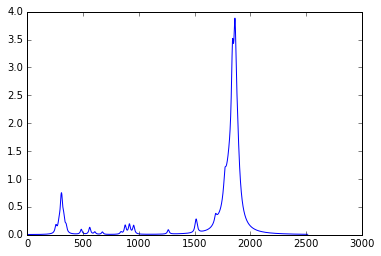

In [176]:
freq = np.linspace(0.0, 400, 2000)
A.x_conjugate = freq
A.g_transform = drude_lorentz.freq

def f(a,N):
    return np.argsort(a)[::-1][:N]

ind = f(np.abs(lambdas_debias), 150)

print np.abs(lambdas_debias[ind])

top_lam = np.zeros_like(lambdas)
for i in ind:
    top_lam[i] = np.abs(lambdas_debias[i])

reproduced_transform = cs_utils.reproduce_transform(A, np.abs(top_lam))

plt.plot(freq*2*np.pi, reproduced_transform)

to_csv = np.vstack((freq*2*np.pi, reproduced_transform))
print to_csv.shape

np.savetxt("transform.csv", to_csv, delimiter=",")

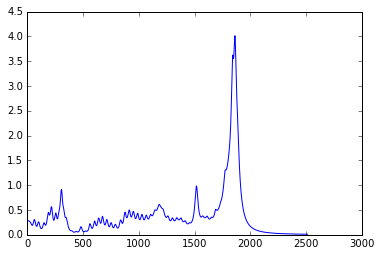

In [136]:
plt.plot(freq*2.0*np.pi, reproduced_transform)

4000


In [178]:
reproduced_cs = np.load('reproduced_CS.npy')
reproduced_sr = np.load('reproduced_SR.npy')
reproduced_hi = np.load('reproduced_HI.npy')

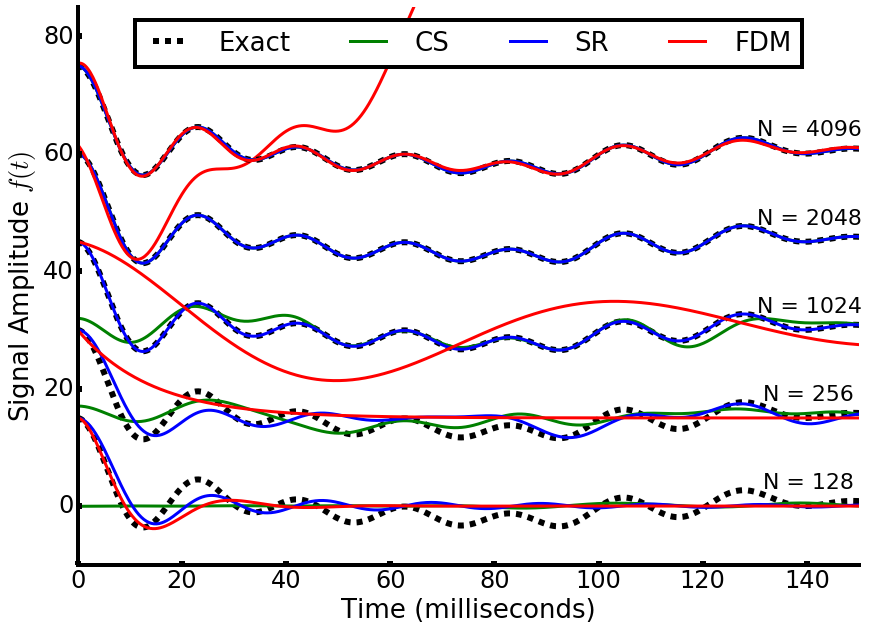

In [302]:

def flip(items, ncol):
    import itertools
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

import prettyplotlib as ppl

l = 3
l_exact = 6
c_cs = 'g'
c_sr = 'b'
c_hi = 'r'
exact_style='--'
cs_style = '-'
sr_style = '-'
hi_style = '-'

fig, ax = plt.subplots(1)
fig.set_size_inches(14, 10)

N = 2
offset = 0
plt.plot(time*1000, signal+offset, linewidth=l_exact, color='k', label='Exact', linestyle=exact_style)
plt.plot(time*1000, reproduced_cs[:, N], linewidth=l, color=c_cs, label='CS', linestyle=cs_style)
plt.plot(time*1000, reproduced_sr[:, N], linewidth=l, color=c_sr, label='SR', linestyle=sr_style)
plt.plot(time*1000, reproduced_hi[:, N], linewidth=l, color=c_hi, label='FDM', linestyle=hi_style)

offset += 15

N = 4
N_CS=5
plt.plot(time*1000, signal+offset, linewidth=l_exact, color='k', linestyle=exact_style)
plt.plot(time*1000, reproduced_cs[:, N_CS]+offset, linewidth=l, color=c_cs, linestyle=cs_style)
plt.plot(time*1000, reproduced_sr[:, N_CS]+offset, linewidth=l, color=c_sr, linestyle=sr_style)
plt.plot(time*1000, reproduced_hi[:, N]+offset, linewidth=l, color=c_hi, linestyle=hi_style)

offset += 15

N = 6
N_CS=7
plt.plot(time*1000, signal+offset, linewidth=l_exact, color='k', linestyle=exact_style)
plt.plot(time*1000, reproduced_cs[:, N_CS]+offset, linewidth=l, color=c_cs, linestyle=cs_style)
plt.plot(time*1000, reproduced_sr[:, N_CS]+offset, linewidth=l, color=c_sr, linestyle=sr_style)
plt.plot(time*1000, reproduced_hi[:, N]+offset, linewidth=l, color=c_hi, linestyle=hi_style)

offset += 15

N = 7
N_CS=9
plt.plot(time*1000, signal+offset, linewidth=l_exact, color='k', linestyle=exact_style)
plt.plot(time*1000, reproduced_cs[:, N_CS]+offset, linewidth=l, color=c_cs, linestyle=cs_style)
plt.plot(time*1000, reproduced_sr[:, N_CS]+offset, linewidth=l, color=c_sr, linestyle=sr_style)
plt.plot(time*1000, reproduced_hi[:, N]+offset, linewidth=l, color=c_hi, linestyle=hi_style)


offset += 15

N = 8
N_CS=12
plt.plot(time*1000, signal+offset, linewidth=l_exact, color='k', linestyle=exact_style)
plt.plot(time*1000, reproduced_cs[:, N_CS]+offset, linewidth=l, color=c_cs, linestyle=cs_style)
plt.plot(time*1000, reproduced_sr[:, N_CS]+offset, linewidth=l, color=c_sr, linestyle=sr_style)
plt.plot(time*1000, reproduced_hi[:, N]+offset, linewidth=l, color=c_hi, linestyle=hi_style)

plt.xlim([0, 0.15*1000])
plt.ylim([-10, 85])

handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(loc='upper center', ncol=4,  shadow=False, fontsize=26)

legend.get_frame().set_linewidth(4)

ax.set_xlabel('Time (milliseconds)', fontsize=26)
ax.set_ylabel('Signal Amplitude $f(t)$', fontsize=26)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(width=6)

ax.yaxis.set_ticks_position('left')
ax.yaxis.set_tick_params(width=6)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)

ax.annotate('N = 128', xy=(131.5, 3), fontsize=22)
ax.annotate('N = 256', xy=(131.5, 15+3), fontsize=22)
ax.annotate('N = 1024', xy=(130.5, 30+3), fontsize=22)
ax.annotate('N = 2048', xy=(130.5, 45+3), fontsize=22)
ax.annotate('N = 4096', xy=(130.5, 60+3), fontsize=22)

plt.savefig('reconstructions.eps', format='eps', dpi=1000)

In [192]:
print reproduced_hi.shape

(4096, 9)


In [290]:
2**8

256